<a href="https://colab.research.google.com/github/AcerPing/AceTibaMe/blob/master/transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile
f = zipfile.ZipFile("drive/My Drive/train.zip")
f.extractall("datas")

In [3]:
import glob
import pandas as pd

dogs = glob.glob("datas/train/dog.*")
cats = glob.glob("datas/train/cat.*")
df = pd.DataFrame({
    "path":dogs+cats,
    "ans":[0]*len(dogs)+[1]*len(cats)})
df

,path,ans
0,datas/train/dog.5656.jpg,0
1,datas/train/dog.8713.jpg,0
2,datas/train/dog.6643.jpg,0
3,datas/train/dog.5301.jpg,0
4,datas/train/dog.2056.jpg,0
...,...,...
24995,datas/train/cat.5152.jpg,1
24996,datas/train/cat.3089.jpg,1
24997,datas/train/cat.9365.jpg,1
24998,datas/train/cat.4735.jpg,1


In [4]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
cnn = VGG16(include_top=False,input_shape=(224,224,3))
for layer in cnn.layers:
  layer.trainable = False
mlp = [#512 * 4 = 2048 (一半不訓練[原本的平均及標準差]，一半訓練[後來的平均及後來的標準差])
    BatchNormalization(),
    Flatten(),
    Dense(256,activation="relu"),
    Dropout(0.25),
    Dense(2,activation="softmax")]
model = Sequential(cnn.layers + mlp)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [5]:
cnn.layers

In [6]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss = SparseCategoricalCrossentropy(),optimizer="adam",metrics=["accuracy"])

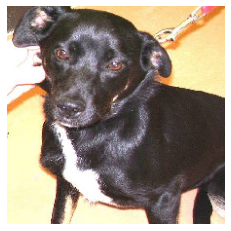

In [7]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

img = load_img(df["path"][0],target_size=(224,224))
plt.axis("off")
plt.imshow(img)

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np
#只要開始處理，就不要df,改用np.array
x = np.array(df["path"])
y = np.array(df["ans"])
x_train,x_test,y_train,y_test = train_test_split( x , y , test_size=0.1 )


In [9]:
from tensorflow.keras.applications.vgg16 import preprocess_input

def get_data(x,y,batch=20):
  idx = np.random.randint(0,len(x),batch)
  x_idx, y_idx = x[idx],y[idx]
  x_ori, x_norm, y_ori = [], [], y_idx
  for p in x_idx:
    img = np.array(load_img(p,target_size=(224,224)))
    img_pre = preprocess_input(img)
    x_ori.append(img)
    x_norm.append(img_pre)
  return np.array(x_ori),np.array(x_norm),np.array(y_ori)
get_data(x_train,y_train,batch=20)


(array([[[[239, 222, 204],
          [200, 179, 162],
          [165, 139, 126],
          ...,
          [138, 130, 111],
          [149, 147, 126],
          [228, 221, 205]],
 
         [[190, 175, 156],
          [227, 208, 191],
          [155, 132, 118],
          ...,
          [159, 152, 134],
          [167, 166, 146],
          [187, 180, 162]],
 
         [[168, 153, 134],
          [190, 173, 155],
          [160, 138, 124],
          ...,
          [151, 145, 129],
          [155, 154, 134],
          [157, 152, 132]],
 
         ...,
 
         [[202, 194, 157],
          [175, 161, 126],
          [204, 181, 149],
          ...,
          [ 65,  72,  90],
          [ 70,  78,  97],
          [ 57,  64,  82]],
 
         [[212, 204, 165],
          [168, 154, 119],
          [187, 164, 132],
          ...,
          [ 66,  73,  91],
          [ 70,  78,  97],
          [ 57,  64,  82]],
 
         [[192, 185, 143],
          [207, 193, 156],
          [184, 161, 129],
   

In [10]:
for i in range(10):
  print("[Times]:",i)
  _, x_batch, y_batch = get_data(x_train,y_train)
  result = model.train_on_batch(x_batch, y_batch)
  print("[Train]:",result)
  _, x_batch, y_batch = get_data(x_test,y_test,100)
  result = model.test_on_batch(x_batch, y_batch)
  print("[Test]:",result)

[Times]: 0
[Train]: [1.3590633869171143, 0.5]
[Test]: [21.465303421020508, 0.6800000071525574]
[Times]: 1
[Train]: [1.0428040027618408, 0.75]
[Test]: [20.142650604248047, 0.7400000095367432]
[Times]: 2
[Train]: [0.795540452003479, 0.949999988079071]
[Test]: [3.5308358669281006, 0.9200000166893005]
[Times]: 3
[Train]: [0.09919440746307373, 0.949999988079071]
[Test]: [5.849918365478516, 0.8799999952316284]
[Times]: 4
[Train]: [1.033409595489502, 0.8500000238418579]
[Test]: [2.6450443267822266, 0.9100000262260437]
[Times]: 5
[Train]: [0.0001064206735463813, 1.0]
[Test]: [1.915497899055481, 0.9300000071525574]
[Times]: 6
[Train]: [0.324215829372406, 0.949999988079071]
[Test]: [3.85064697265625, 0.9200000166893005]
[Times]: 7
[Train]: [1.1413137912750244, 0.8999999761581421]
[Test]: [3.8450927734375, 0.8799999952316284]
[Times]: 8
[Train]: [0.28154802322387695, 0.949999988079071]
[Test]: [3.3271539211273193, 0.8799999952316284]
[Times]: 9
[Train]: [0.8203192949295044, 0.8999999761581421]
[T

In [11]:
model.predict(x_batch)

array([[0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [7.7588840e-17, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [9.1779157e-31, 1.0000000e+00],
       [6.3226526e-23, 1.0000000e+00],
       [1.0000000e+00, 8.7646269e-13],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [5.5323981e-29, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.

In [12]:
x_ori,x_batch,y_batch = get_data(x_test, y_test, 1000)
model.evaluate(x_batch,y_batch)

32/32 [==============================] - 9s 273ms/step - loss: 3.4929 - accuracy: 0.9050


[3.4929428100585938, 0.9049999713897705]

In [13]:
x_batch.shape

(1000, 224, 224, 3)

In [14]:
#argmax:找最大值的index，通常都是最後一個軸(-1)
pre = model.predict(x_batch).argmax(axis=-1)
pre

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,

In [15]:
trans = ["dogs","cats"]

In [16]:
np.nonzero(pre != y_batch)[0]

array([  4,   6,  13,  18,  21,  23,  28,  36,  37,  39,  45,  47,  87,
        89,  99, 101, 106, 113, 124, 130, 139, 144, 181, 201, 203, 204,
       208, 220, 223, 240, 257, 261, 262, 277, 288, 309, 323, 337, 339,
       360, 373, 375, 376, 380, 395, 399, 425, 429, 448, 455, 462, 465,
       468, 476, 492, 507, 554, 557, 560, 582, 597, 600, 604, 629, 686,
       688, 689, 700, 707, 719, 731, 737, 761, 779, 788, 810, 817, 836,
       842, 843, 846, 852, 865, 868, 873, 875, 878, 881, 889, 895, 908,
       910, 924, 928, 996])

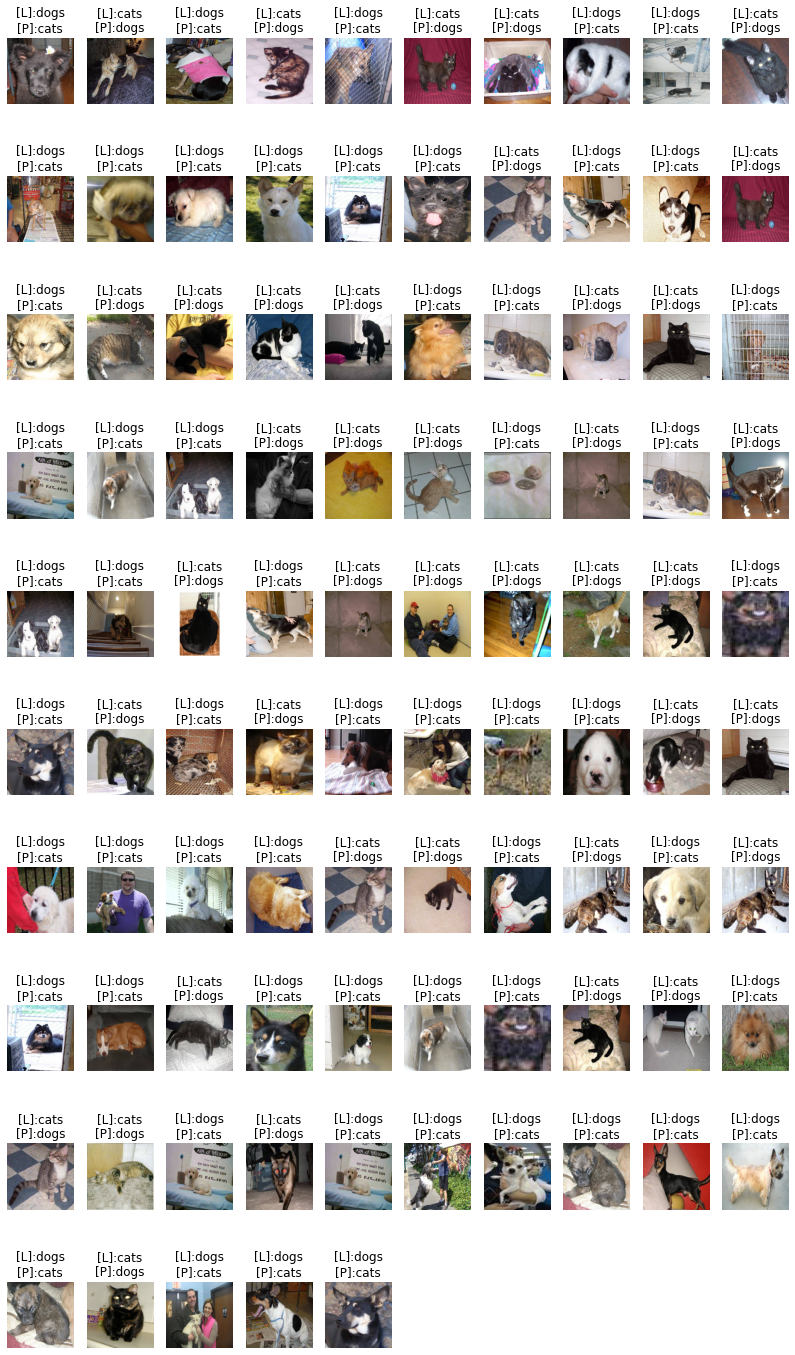

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(14, 25))
idx = np.nonzero(pre != y_batch)[0]
idx = idx[:200]
width = 10
height = len(idx) // width + 1
for i, d  in enumerate(idx):
    img, label, p = x_ori[d], y_batch[d], pre[d]
    t = "[L]:{}\n[P]:{}".format(trans[label], trans[p])
    plt.subplot(height, width, i+1)
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)